# Figure6 peaks overlap

## Plots

* Peaks overlap
* Peaks overlap with ENCODE MACS2 default
* Peaks overlap with ENCODE downloaded files
* Peaks overlap with ENCODE processed the same tool the same way.


## Input

* Peak Calling Summary - aging.tsv
* Peak Calling Summary - encode.tsv
* Downloaded GSM BED files for encode CD14+ at `/mnt/stripe/bio/experiments/figures`
* * GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak
* * GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak
* * GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak
* * GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak
* * GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak



In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from pathlib import Path
import downstream.bed_metrics as bm
import downstream.loci_of_interest as loi
import glob
from collections import OrderedDict, Counter
from IPython.display import display
import pandas as pd


OLD_COLOR = '#E41A1C'
YOUNG_COLOR = '#377EB8'
AGE_PALETTE = {'Old': OLD_COLOR, 'Young': YOUNG_COLOR}

TOOLS_PALETTE = {'MACS_BROAD': "#EDEDED", 'SICER': "#EDEDED", 'SPAN': '#FBE5D6'}

MODIFICATIONS = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']

df = pd.read_csv('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/Y20O20_peaks_summary_uli.tsv', 
                 sep='\t', comment='#')
df = df.loc[df['status'] != 'failed'][['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
print(set(df['tool']))
display(df.head(1))

{'macs_broad', 'span', 'sicer'}


,donor,modification,tool,peaks,procedure,file
0,OD1,H3K27ac,sicer,32168,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...


In [2]:
def plot_overlap(df, toshow):
    # Compute overlaps
    dft = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])

    for m, tps in toshow.items():
        for (tool, procedure) in tps:
            files = df.loc[np.logical_and(df['tool'].str.lower() == tool.lower(), 
                              np.logical_and(df['modification'] == m, 
                                             df['procedure'] == procedure))]['file']

            paths = [Path(f) for f in files]
            df_path = '/mnt/stripe/figures/overlap_{}_{}_{}.tsv'.format(m, tool, procedure)
            mt = bm.load_or_build_metrics_table(paths, paths, Path(df_path),
                                                jaccard=False,
                                                threads=30)
            for r in mt.index:
                for c in mt.columns:
                    overlap = mt.loc[r][c]
                    dft.loc[len(dft)] = (r + "@" + c, m, tool, procedure, overlap, 'all')

            # Look for replicated peaks
            if tool == 'SPAN':
                pattern='/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/{}/span_replicated/*any*.bed'.format(m)
                print(pattern)
                replicated_peaks = [Path(f) for f in glob.glob(pattern)]
                print(replicated_peaks)
                if len(replicated_peaks) != 1:
                    print(replicated_peaks)
                    print("ERROR")
# Ignore overlap with REPLICATED SPAN for now
#             df_path = '/mnt/stripe/bio/experiments/figures/overlap_replicated_vs_{}_{}_{}.tsv'.format(m, tool, procedure)
#             mt = bm.load_or_build_metrics_table(replicated_peaks, 
#                                                 paths, 
#                                                 Path(df_path),
#                                                 jaccard=False,
#                                                 threads=30)
#             for r in mt.index:
#                 for c in mt.columns:
#                     overlap = mt.loc[r][c]
#                     dft.loc[len(dft)] = (r + "@" + c, m, tool, procedure, overlap, 'replicated_vs')

#             df_path = '/mnt/stripe/bio/experiments/figures/overlap_vs_replicated_{}_{}_{}.tsv'.format(m, tool, procedure)
#             mt = bm.load_or_build_metrics_table(paths, 
#                                                 replicated_peaks, 
#                                                 Path(df_path),
#                                                 jaccard=False,
#                                                 threads=30)
#             for r in mt.index:
#                 for c in mt.columns:
#                     overlap = mt.loc[r][c]
#                     dft.loc[len(dft)] = (r + "@" + c, m, tool, procedure, overlap, 'vs_replicated')

    dft['mp'] = dft['modification'] + " " + dft['tool'] + " " + dft['procedure']    

    axs = {}
    mpl = len(set(dft['mp']))
    fig = plt.figure(figsize=(int(len(set(dft['mp'])) * .75), 4))
    offset = 0
    for m in MODIFICATIONS:
        data = dft.loc[dft['modification'] == m]
        xlabels = []
        for t in data['tool']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['mp']))
        ax = plt.subplot2grid((1, mpl), (0, offset), colspan=w)

        ax = sns.barplot(data=data, 
                 x="tool", y="overlap",
                 ci="sd", capsize=.2, errwidth=2,
                 palette = TOOLS_PALETTE,
                 edgecolor="black")

        ax = sns.swarmplot(data=data, 
                           x="tool", y="overlap",
                           size=1, alpha=1.0,
                           hue='direction',
                           palette={'all': 'black', 'replicated_vs': 'red', 'vs_replicated': 'yellow'})


        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Overlap')
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
    plt.tight_layout()

# Tuned overlap

[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_MACS_BROAD_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_SICER_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/span_replicated/*any*.bed
[]
[]
ERROR
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_MACS_BROAD_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SICER_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27me3/span_replicated/*any*.bed
[]
[]
ERROR
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_MACS_BROAD_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SICER_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K36me3/span_replicated/*an

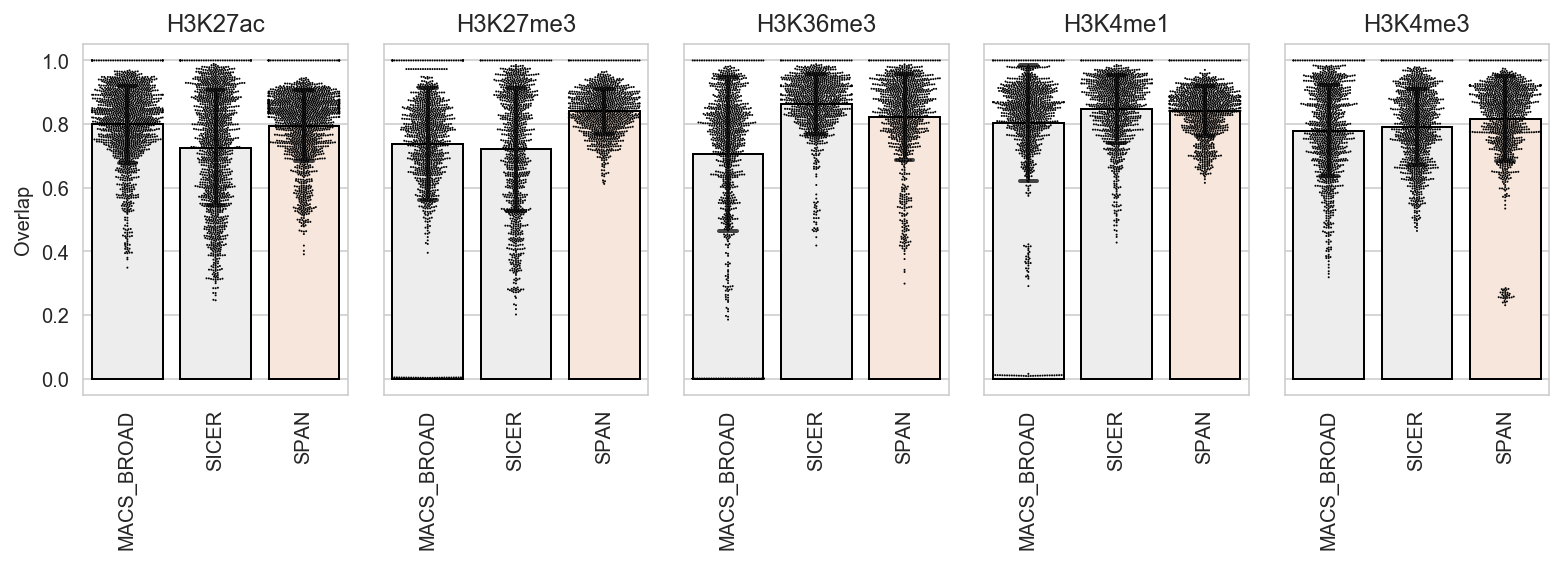

In [3]:
toshow = OrderedDict([
    ("H3K27ac", [("MACS_BROAD", "tuned"), ("SICER", "tuned"), ("SPAN", "tuned")]),
    ("H3K27me3", [("MACS_BROAD", "tuned"), ("SICER", "tuned"), ("SPAN", "tuned")]),
    ("H3K36me3", [("MACS_BROAD", "tuned"), ("SICER", "tuned"), ("SPAN", "tuned")]),
    ("H3K4me1", [("MACS_BROAD", "tuned"), ("SICER", "tuned"), ("SPAN", "tuned")]),
    ("H3K4me3", [("MACS_BROAD", "tuned"), ("SICER", "tuned"), ("SPAN", "tuned")])
])
with PdfPages('/mnt/stripe/figures/overlap_tuned.pdf') as pdf:
    plot_overlap(df, toshow)
    pdf.savefig()

# Figure6 overlap

[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27ac/span_replicated/*any*.bed
[]
[]
ERROR
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K27me3/span_replicated/*any*.bed
[]
[]
ERROR
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SPAN_tuned.tsv
/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/H3K36me3/span_replicated/*any*.bed
[]
[]
ERROR
[Skipped]: Already exists /mnt/stripe/figures/ove

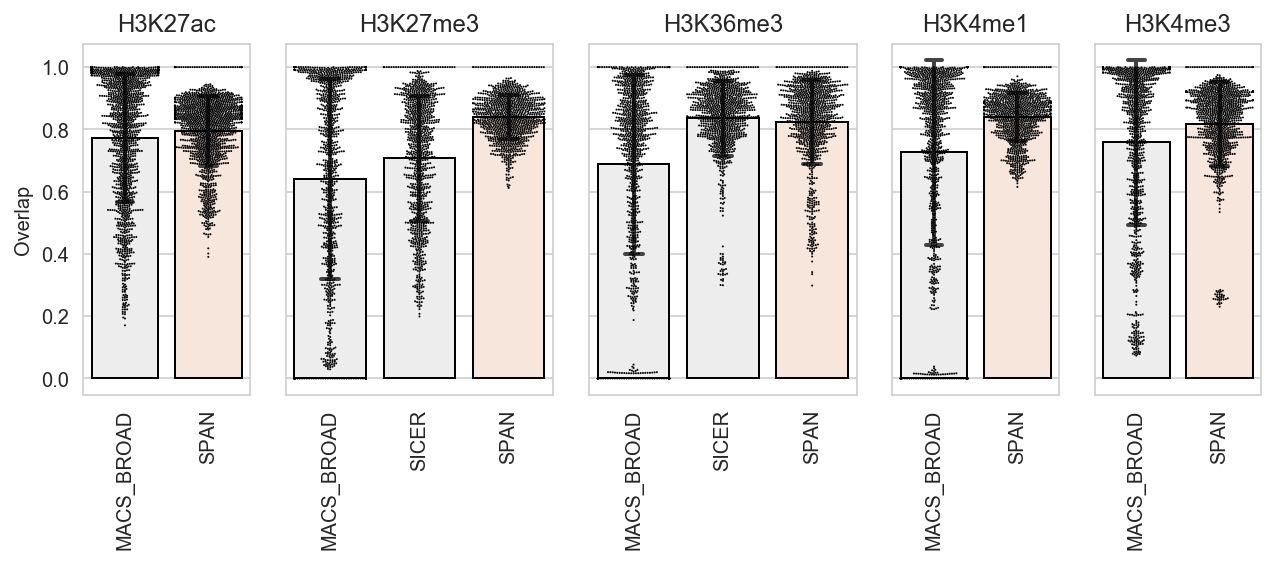

In [4]:
toshow = OrderedDict([
    ("H3K27ac", [("MACS_BROAD", "default"), ("SPAN", "tuned")]),
    ("H3K27me3", [("MACS_BROAD", "default"), ("SICER", "default"), ("SPAN", "tuned")]),
    ("H3K36me3", [("MACS_BROAD", "default"), ("SICER", "default"), ("SPAN", "tuned")]),
    ("H3K4me1", [("MACS_BROAD", "default"), ("SPAN", "tuned")]),
    ("H3K4me3", [("MACS_BROAD", "default"), ("SPAN", "tuned")])
])
with PdfPages('/mnt/stripe/figures/overlap.pdf') as pdf:
    plot_overlap(df, toshow)
    pdf.savefig()

# Plot standard deviation of overlap values

In [25]:
df.head()

,donor,modification,tool,peaks,procedure,file
0,OD1,H3K27ac,sicer,32168,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...
1,OD2,H3K27ac,sicer,38292,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...
2,OD3,H3K27ac,sicer,41025,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...
3,OD4,H3K27ac,sicer,41875,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...
4,OD5,H3K27ac,sicer,33604,tuned,/mnt/stripe/bio/experiments/configs/Y20O20/ben...


In [27]:
# Compute overlaps
df_overlap = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])

for m, tps in toshow.items():
    for (tool, procedure) in tps:
        files = df.loc[np.logical_and(df['tool'].str.lower() == tool.lower(), 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']

        paths = [Path(f) for f in files]
        df_path = '/mnt/stripe/figures/overlap_{}_{}_{}.tsv'.format(m, tool, procedure)
        mt = bm.load_or_build_metrics_table(paths, paths, Path(df_path),
                                            jaccard=False,
                                            threads=30)
        for r in mt.index:
            for c in mt.columns:
                overlap = mt.loc[r][c]
                df_overlap.loc[len(df_overlap)] = (r + "@" + c, m, tool, procedure, overlap, 'all')

# display(df_overlap.head())

[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27ac_SPAN_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K27me3_SPAN_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SICER_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K36me3_SPAN_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K4me1_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K4me1_SPAN_tuned.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K4me3_MACS_BROAD_default.tsv
[Skipped]: Already exists /mnt/stripe/figures/overlap_H3K4me3_SPAN_tuned.tsv


Mean overlap


,modification,tool,procedure,overlap
0,H3K27ac,MACS_BROAD,default,0.771847
1,H3K27ac,SPAN,tuned,0.794909
2,H3K27me3,MACS_BROAD,default,0.639504
3,H3K27me3,SICER,default,0.707211
4,H3K27me3,SPAN,tuned,0.840060
5,H3K36me3,MACS_BROAD,default,0.688490
6,H3K36me3,SICER,default,0.835966
7,H3K36me3,SPAN,tuned,0.822389
8,H3K4me1,MACS_BROAD,default,0.725876
9,H3K4me1,SPAN,tuned,0.840086


STD overlap


,modification,tool,procedure,overlap
0,H3K27ac,MACS_BROAD,default,0.206533
1,H3K27ac,SPAN,tuned,0.111696
2,H3K27me3,MACS_BROAD,default,0.320914
3,H3K27me3,SICER,default,0.200552
4,H3K27me3,SPAN,tuned,0.071727
5,H3K36me3,MACS_BROAD,default,0.287571
6,H3K36me3,SICER,default,0.120940
7,H3K36me3,SPAN,tuned,0.135191
8,H3K4me1,MACS_BROAD,default,0.298256
9,H3K4me1,SPAN,tuned,0.078222


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/oleg/miniconda2/envs/py35/lib/python3.5/site-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


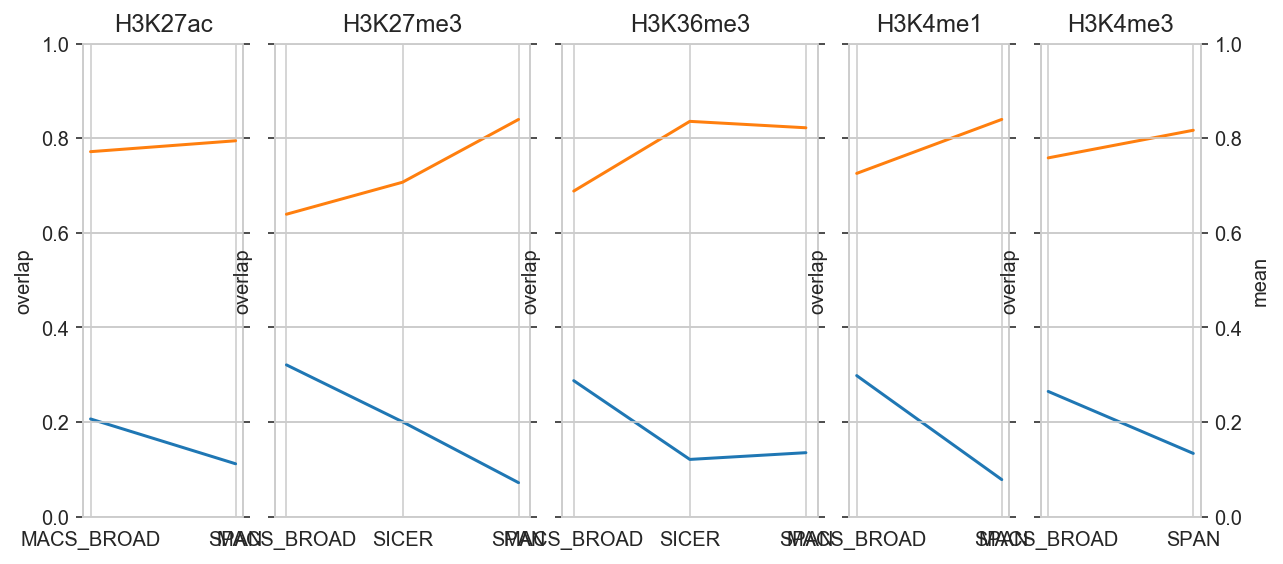

In [46]:
df_mean = df_overlap.groupby(['modification', 'tool', 'procedure']).mean().reset_index()
print('Mean overlap')
display(df_mean)

df_std = df_overlap.groupby(['modification', 'tool', 'procedure']).std().reset_index()
print('STD overlap')
display(df_std)


df_mean['mp'] = df_mean['modification'] + " " + df_mean['tool'] + " " + df_mean['procedure']
mpl = len(set(df_mean['mp']))
fig = plt.figure(figsize=(int(mpl * .75), 4))
offset = 0
for m in MODIFICATIONS:
    datam = df_mean.loc[df_mean['modification'] == m]
    datas = df_std.loc[df_std['modification'] == m]
    xlabels = []
    for t in datam['tool']:
        if t not in xlabels:
            xlabels.append(t)
    w = len(set(datam['mp']))
    ax = plt.subplot2grid((1, mpl), (0, offset), colspan=w)
    sns.lineplot(ax=ax, x='tool', y='overlap', markers=True, data=datas)
    ax.legend().set_visible(False)
    ax.set_ylim(0, 1)
    if offset > 0:
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('std')
    
    ax2 = ax.twinx()    
    sns.lineplot(ax=ax, x='tool', y='overlap', markers=True, data=datam)
    if m != MODIFICATIONS[-1]:
        ax2.get_yaxis().set_ticklabels([])
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('mean')
   
    offset += w
    ax.set_xlabel('')
    ax.set_title(m)
    plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)

plt.tight_layout()

with PdfPages('/mnt/stripe/figures/overlap_mean_std.pdf') as pdf:
    pdf.savefig()

# CODE to plot 2 ways overlap with ENCODE

In [7]:
# Plot 2way overlaps on the single plot vs ENCODE with separation to red/blue
def plot_overlaps_2(dft):
    dft["age"] = "Young"
    dft.loc[["OD" in v for v in dft['id']], "age"] = "Old"

    
    total = len(set(dft['modification'] + " " + dft['tool'] + " " + dft['procedure']))
    
    dft['tool_binary'] = 'span'
    dft.loc[dft['tool'] != 'SPAN', 'tool_binary'] = 'other'
    dft['mp'] = dft['direction']+ '-' + dft['tool_binary'] 

    TOOL_DIRECTION_PALETTE = {
        'aging@encode-span': '#FBE5D6',
        'encode@aging-span': '#FBE5D6',
        'aging@encode-other': '#EDEDED',
        'encode@aging-other': '#EDEDED',
    }
    
    ms = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']
    axs = {}
    fig = plt.figure(figsize=(int(total * .75), 4))
    offset = 0
    for m in MODIFICATIONS:
        data = dft.loc[dft['modification'] == m]
        xlabels = []
        for t in data['tool']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['tool']))
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)
        
        # Bar plots
        ax = sns.barplot(data=data, 
                         x="tool", y="overlap",
                         ci="sd", capsize=.2, errwidth=2,
                         color='#EDEDED',
#                          palette = TOOL_DIRECTION_PALETTE,
                         hue = "direction",
                         edgecolor="black",
                     )

#         ax = sns.barplot(data=data.loc[data['tool'] == 'SPAN'], 
#                          x="tool", y="overlap",
#                          ci="sd", capsize=.2, errwidth=2,
#                          color='#FBE5D6',
# #                          palette = TOOL_DIRECTION_PALETTE,
#                          hue = "direction",
#                          edgecolor="black",
#                         )


        # Add jitter with the swarmplot function.
        ax = sns.swarmplot(data=data.loc[data['age']=='Young'], 
                           x="tool", y="overlap",
                           size=3,
                           hue="direction",
                           palette=[YOUNG_COLOR, YOUNG_COLOR],
                           dodge=True)

        # Add jitter with the swarmplot function.
        ax = sns.swarmplot(data=data.loc[data['age']=='Old'], 
                           x="tool", y="overlap",
                           size=3,
                           hue="direction",
                           palette=[OLD_COLOR, OLD_COLOR],
                           dodge=True)

        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Overlap')
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
#     plt.tight_layout()

# Overlap with ENCODE MACS2 default

In [ ]:
import os
from scripts.util import run

dfe = pd.read_csv('/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/cd14encode_peaks_summary.tsv', 
                  sep='\t', comment='#')
dfe = dfe[['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
dfe = dfe.loc[np.logical_and(dfe['tool'] == 'MACS2', dfe['procedure'] == 'default')]
display(dfe)

method = 'union'
encode_macs2_peaks = {}
for modification in set(dfe['modification']):
    result_file = '/mnt/stripe/bio/experiments/figures/{}_encode_{}.bed'.format(modification, method)
    if not os.path.exists(result_file):
        files = list(dfe.loc[dfe['modification'] == modification]['file'])
        cmd = ['bash', '/mnt/stripe/washu/bed/{}.sh'.format(method)] + files
        with open(result_file, mode='w') as out:
            run([cmd], stdout=out)
    encode_macs2_peaks[modification] = result_file
display(encode_macs2_peaks)

In [ ]:
bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])

for m, tps in toshow.items():
    for (tool, procedure) in tps:
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_macs2_peaks[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_macs2_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_macs2_peaks[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf)

# VS ENCODE downloaded BED files
Actuallly this is not the 100% truth, since we get some females here as well as tool bias.

In [ ]:
encode_peaks_bed={
    'H3K27ac': '/mnt/stripe/bio/experiments/figures/GSM1003559_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27acPk.broadPeak',
    'H3K27me3': '/mnt/stripe/bio/experiments/figures/GSM1003564_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k27me3Pk.broadPeak',
    'H3K36me3': '/mnt/stripe/bio/experiments/figures/GSM1003562_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k36me3Pk.broadPeak',
    'H3K4me1': '/mnt/stripe/bio/experiments/figures/GSM1003535_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me1Pk.broadPeak',
    'H3K4me3': '/mnt/stripe/bio/experiments/figures/GSM1003536_hg19_wgEncodeBroadHistoneMonocd14ro1746H3k04me3Pk.broadPeak'
}

bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
xlabels = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        xlabels.append(tool)
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        # Aging @ ENCODE
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        aging_at_encode = bm.load_or_build_metrics_table([Path(f) for f in files],
                                             [Path(encode_peaks_bed[modification])],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in aging_at_encode.index:
            for c in aging_at_encode.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, aging_at_encode.loc[r][c], "aging@encode")
        
        # ENCODE @ Aging
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_bed_{}_{}_{}_{}.tsv'\
        .format(method, m, tool, procedure)
        encode_at_aging = bm.load_or_build_metrics_table([Path(encode_peaks_bed[modification])],
                                            [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in encode_at_aging.index:
            for c in encode_at_aging.columns:
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, encode_at_aging.loc[r][c], "encode@aging")


plot_overlaps_2(bigdf, xlabels)

# Overlap with ENCODE processed the same manner

In [8]:
import glob

# ENCODE male CD14 samples
encode_gsms = {
    'H3K27ac': 'GSM1102782',
    'H3K27me3': 'GSM1102785',
    'H3K36me3': 'GSM1102788',
    'H3K4me1': 'GSM1102793',
    'H3K4me3': 'GSM1102797',
}


dfe = pd.read_csv('/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/cd14encode_peaks_summary_uli.tsv', 
                  sep='\t', comment='#')
dfe = dfe[['donor', 'modification', 'tool', 'peaks', 'procedure', 'file']]
dfe = dfe.loc[[d in encode_gsms.values() for d in dfe['donor']]]
display(dfe)


bigdf = pd.DataFrame(columns=['id', 'modification', 'tool', 'procedure', 'overlap', 'direction'])
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        print(m, tool, procedure)
        files = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]['file']
        encode_files = dfe.loc[np.logical_and(dfe['tool'] == tool, 
                          np.logical_and(dfe['modification'] == m, 
                                         dfe['procedure'] == procedure))]['file']

        print("ENCODE paths", list(encode_files))
        print("FILES", len(files))
        
        # Compute Aging @ ENCODE overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_{}_{}_{}_{}.tsv'\
            .format('tuned', m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in files], 
                                             [Path(f) for f in encode_files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "aging@encode")

        # Compute ENCODE @ Aging overlap
        dfe_path = '/mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_{}_{}_{}_{}.tsv'\
            .format('tuned', m, tool, procedure)
        mte = bm.load_or_build_metrics_table([Path(f) for f in encode_files],
                                             [Path(f) for f in files],
                                             Path(dfe_path),
                                            jaccard=False,
                                            threads=30)  
        for r in mte.index:
            for c in mte.columns:
                overlap = mte.loc[r][c]
                bigdf.loc[len(bigdf)] = (r + "@" + c, m, tool, procedure, overlap, "encode@aging")

,donor,modification,tool,peaks,procedure,file
0,GSM1102782,H3K27ac,SPAN,25156,tuned,/mnt/stripe/bio/experiments/configs/cd14encode...
2,GSM1102782,H3K27ac,SPAN,25156,default,/mnt/stripe/bio/experiments/configs/cd14encode...
4,GSM1102782,H3K27ac,MACS2,29842,tuned,/mnt/stripe/bio/experiments/configs/cd14encode...
6,GSM1102782,H3K27ac,MACS2,25731,default,/mnt/stripe/bio/experiments/configs/cd14encode...
8,GSM1102785,H3K27me3,SPAN,6515,tuned,/mnt/stripe/bio/experiments/configs/cd14encode...
11,GSM1102785,H3K27me3,SPAN,32005,default,/mnt/stripe/bio/experiments/configs/cd14encode...
14,GSM1102785,H3K27me3,MACS2,9042,tuned,/mnt/stripe/bio/experiments/configs/cd14encode...
18,GSM1102785,H3K27me3,MACS2,14948,default,/mnt/stripe/bio/experiments/configs/cd14encode...
20,GSM1102785,H3K27me3,SICER,27176,tuned,/mnt/stripe/bio/experiments/configs/cd14encode...
24,GSM1102785,H3K27me3,SICER,31899,default,/mnt/stripe/bio/experiments/configs/cd14encode...


H3K27ac MACS2 default
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/H3K27ac/macs_broad/1.0E-4/CD14_GSM1102782_UW_r0_H3K27ac_broad1.0E-4_peaks.broadPeak']
FILES 38
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_MACS2_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_MACS2_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27ac_MACS2_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27ac_MACS2_default.tsv
H3K27ac SPAN tuned
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/H3K27ac/span/CD14_GSM1102782_UW_r0_H3K27ac_200_1.0E-6_5_peaks.bed']
FILES 38
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_SPAN_tuned.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27ac_SPAN_tuned.tsv
C

  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27me3_MACS2_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27me3_MACS2_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27me3_MACS2_default.tsv
H3K27me3 SICER default
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/H3K27me3/sicer/1.0E-6_600/CD14_GSM1102785_UW_r0_H3K27me3-W200-G600-FDR1.0E-6-island.bed']
FILES 32
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27me3_SICER_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K27me3_SICER_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27me3_SICER_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K27me3_SICER_default.tsv
H3K27me3 SPAN tuned
ENCODE paths ['/mnt/stripe/bi

  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K36me3_MACS2_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K36me3_MACS2_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K36me3_MACS2_default.tsv
H3K36me3 SICER default
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/H3K36me3/sicer/1.0E-6_600/CD14_GSM1102788_UW_r0_H3K36me3-W200-G600-FDR1.0E-6-island.bed']
FILES 32
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K36me3_SICER_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K36me3_SICER_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K36me3_SICER_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K36me3_SICER_default.tsv
H3K36me3 SPAN tuned
ENCODE paths ['/mnt/stripe/bi

  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K4me1_MACS2_default.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K4me1_MACS2_default.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K4me1_MACS2_default.tsv
H3K4me1 SPAN tuned
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark/H3K4me1/span/CD14_GSM1102793_UW_r0_H3K4me1_200_1.0E-8_10_peaks.bed']
FILES 32
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K4me1_SPAN_tuned.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_aging_at_encode_tuned_H3K4me1_SPAN_tuned.tsv
Calculating metrics:  /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K4me1_SPAN_tuned.tsv
  [Saved] /mnt/stripe/bio/experiments/figures/overlap_encode_at_aging_tuned_H3K4me1_SPAN_tuned.tsv
H3K4me3 MACS2 default
ENCODE paths ['/mnt/stripe/bio/experiments/configs/cd14encode/benchmark

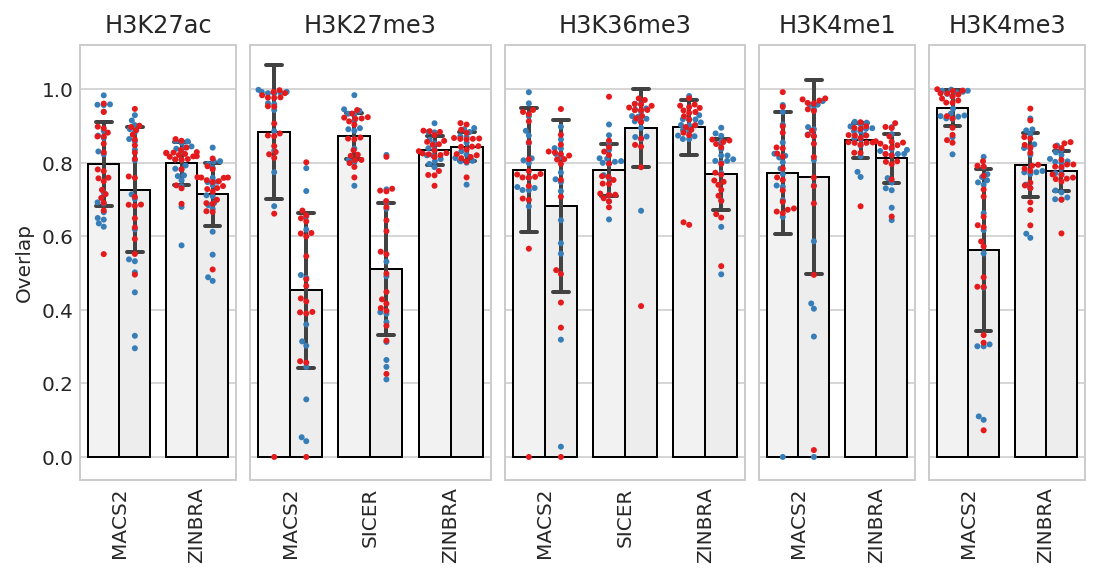

In [9]:
with PdfPages('/mnt/stripe/figures/encode_overlap.pdf') as pdf:
    plot_overlaps_2(bigdf)
    pdf.savefig()